In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
fname = "Obfuscated-MalMem2022.csv"
fpath = "/Documents/Datasets/CICMalMem2022"
export_path = "/Documents/Datasets/CICMalMem2022/clean/mal-mem-2022.npz"

df = pd.read_csv(fpath + "/" + fname)
df.drop("Class", axis=1, inplace=True)
df.head(5)

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,389,221,26,24,116,0,121,87,0,8
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,392,222,26,24,118,0,122,87,0,8
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,395,222,26,27,118,0,120,88,0,8
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,395,222,26,27,118,0,120,88,0,8
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,392,222,26,24,118,0,124,87,0,8


In [3]:
n_samples = df.shape[0]
n_variables = df.shape[1] - 1
anomaly_ratio = len(df[df["Category"] != "Benign"]) / n_samples
cat_cols = df.select_dtypes(exclude=np.number).columns
num_cols = df.select_dtypes(include=np.number).columns
df_info = pd.DataFrame(
    [[n_samples, n_variables, len(cat_cols), len(num_cols), anomaly_ratio]],
    columns=["# samples", "# variables", "# categorical", "# numerical", "anomaly ratio"]
)
df_info

,# samples,# variables,# categorical,# numerical,anomaly ratio
0,58596,55,1,55,0.5


In [4]:
df[df["Category"] != "Benign"]["Category"].value_counts()

Ransomware-Maze-77a13e7807280fd8ca45bd2f60b65884316fba648401547f199695af0e6da190-6.raw         2
Spyware-Transponder-00eb051cf4d001136f9aae0dee46dea7588f2691ad191fd5d6ed721e1581d194-2.raw     2
Spyware-Transponder-0e43c34e27958957b9b5e4abf6f4ce854b36c2e350c808b7c8680cb1455b5ae5-4.raw     2
Spyware-Transponder-0e54a859d428419d0624985943e67116e5983a8017be9293469978e3432bbde4-9.raw     2
Spyware-Transponder-00e454e6d99f48f9d5174e91d138362abb0a35787d9b40aa348ec64b6131e764-5.raw     2
                                                                                              ..
Trojan-Emotet-0bfc54aaf2776618d3c7c166ee16ef527c0a53e0a3cc20dde48e35a841c22488-1.raw           1
Trojan-Refroso-47bdaea6d77ba34cbcd71740de9281be-1.raw                                          1
Trojan-Zeus-1faa8b89a73240f64c802ee0df48d2dfd0bf2f7a1bc7ee92f5a6cfe9f46e0625-7.raw             1
Spyware-180solutions-0cd0fbba001b8627976e5aeee0c982e446c85869a09f7bfa9a38d4100427e724-9.raw    1
Trojan-Scar-2b0d3a766ce4d6d676

In [5]:
families, categories = [], []
idx = df[df["Category"] != "Benign"]["Category"].str.index("-")
for cat in df["Category"]:
    if "Benign" == cat:
        families.append("Benign")
        categories.append("Benign")
    else:
        idx = cat.index("-")
        families.append(
            cat[:idx]
        )
        categories.append(
            cat[idx+1:cat.index("-",idx + 1)]
        )

df["MalwareCategory"] = families
df["MalwareFamilies"] = categories

In [6]:
df.groupby("MalwareCategory")["MalwareFamilies"].value_counts()

MalwareCategory  MalwareFamilies
Benign           Benign             29298
Ransomware       Shade               2128
                 Ako                 2000
                 Conti               1988
                 Maze                1958
                 Pysa                1717
Spyware          Transponder         2410
                 Gator               2200
                 180solutions        2000
                 CWS                 2000
                 TIBS                1410
Trojan           Refroso             2000
                 Scar                2000
                 Emotet              1967
                 Zeus                1950
                 Reconyc             1570
Name: MalwareFamilies, dtype: int64

In [7]:
nan_cols = df.columns[df.isna().any()]
inf_cols = df.columns[df.isin([-np.inf, np.inf]).any()]
print("NaN cols: {}".format(nan_cols))
print("INF cols: {}".format(inf_cols))
print("OK" if len(nan_cols) + len(inf_cols) == 0 else "NAN and/or INF values encountered")

NaN cols: Index([], dtype='object')
INF cols: Index([], dtype='object')
OK


In [8]:
uniq_cols = df.columns[df.nunique() <= 1]

df = df.drop(uniq_cols, axis=1)
assert len(df.columns[df.nunique() <= 1]) == 0, "There are still columns with unique values"
print("Removed columns with a unique value: {}".format(uniq_cols))

Removed columns with a unique value: Index(['pslist.nprocs64bit', 'handles.nport',
       'svcscan.interactive_process_services'],
      dtype='object')


In [9]:
num_df = df.select_dtypes(include=np.number)
X = num_df.to_numpy()
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

assert np.allclose(X_scaled.min(axis=1), 0.), "Detected variables with min != 0."
assert np.allclose(X_scaled.max(axis=1), 1.), "Detected variables with max != 1."

In [10]:
# Convert labels
df["Label"] = df["MalwareCategory"]
df.loc[df["MalwareCategory"] != "Benign", "Label"] = 1
df.loc[df["MalwareCategory"] == "Benign", "Label"] = 0

In [11]:
labels = df["Label"].to_numpy()
to_export = np.concatenate(
    (X_scaled, np.expand_dims(labels, 1)),
    axis=1
)
# Export file
np.savez(export_path, malmem2022=to_export.astype(np.float64))

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(X)
std_scaled_X = scaler.transform(X)
model = PCA()
model.fit(std_scaled_X)
Z = model.transform(X_scaled)
df_pca = pd.concat([pd.DataFrame(Z), df["MalwareCategory"], df["MalwareFamilies"]], axis=1)
df_pca = df_pca.rename(columns={i: 'PC-{}'.format(i + 1 ) for i in range(Z.shape[1])})
explained_var = model.explained_variance_[0:20]
cum_prop = (np.cumsum(explained_var) / sum(explained_var))[0:20]

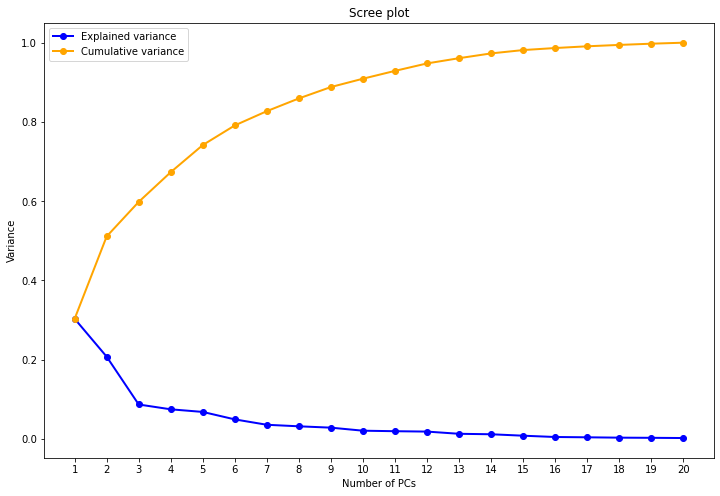

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

x_labels = [i+1 for i in range(len(explained_var))]

ax.plot(x_labels, explained_var / explained_var.sum(), marker='o', markersize=6, color='blue', linewidth=2, label="Explained variance")
ax.plot(x_labels, cum_prop, marker='o', color='orange', linewidth=2, label="Cumulative variance")
ax.legend()
ax.set_xticks(x_labels)
ax.set_title("Scree plot")
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Variance")
plt.show()

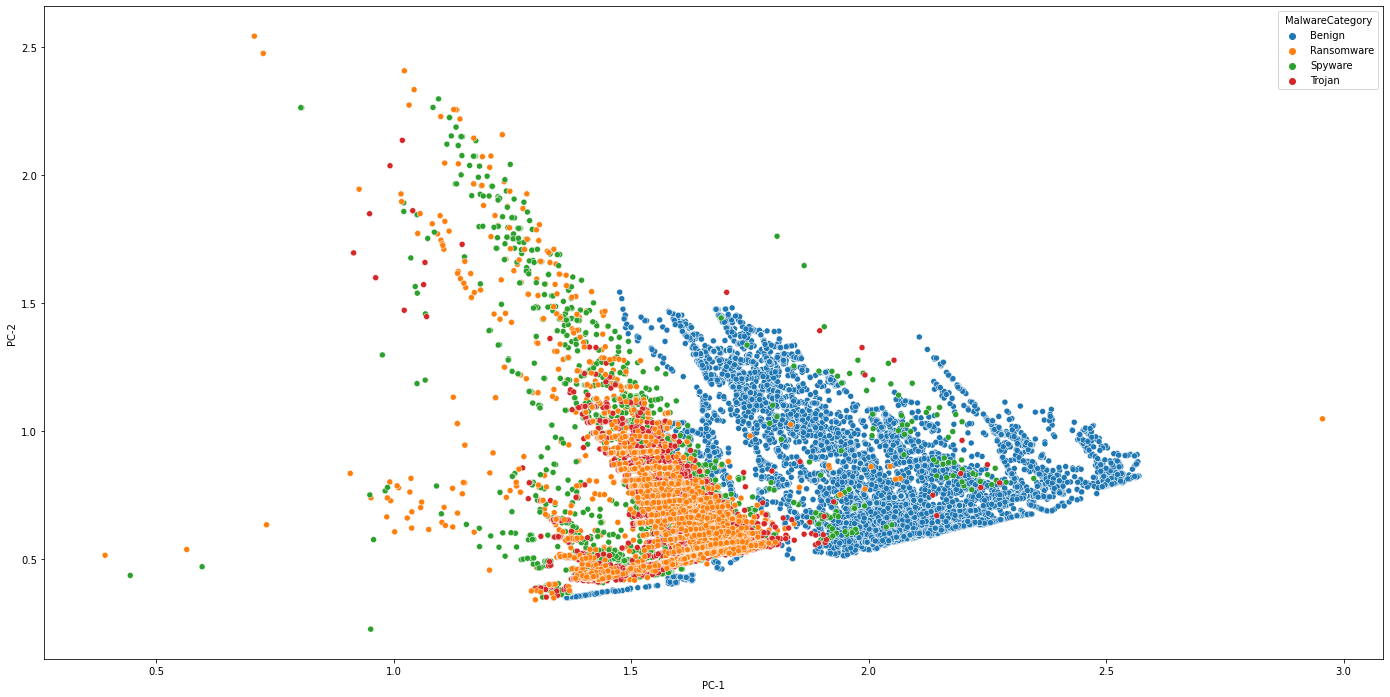

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 12))

sns.scatterplot(data=df_pca, x="PC-1", y="PC-2", hue="MalwareCategory", ax=ax)

plt.show()

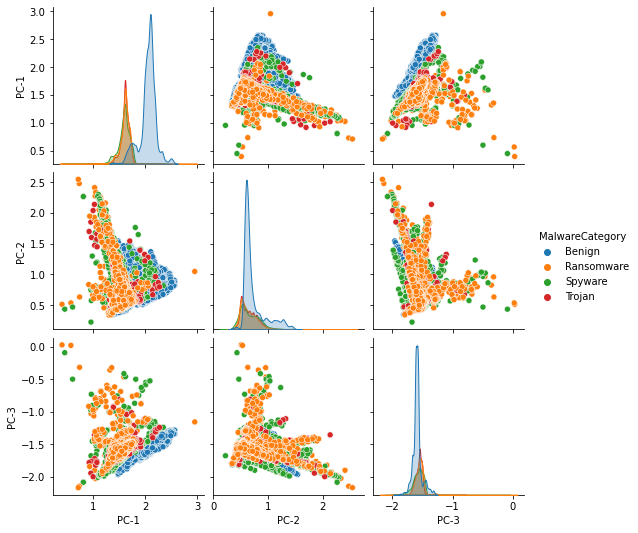

In [15]:
sns.pairplot(df_pca, vars=["PC-1", "PC-2", "PC-3"], hue="MalwareCategory")